<span style='color:Blue ;
             font-size:30px;'>
    Оценка качества соединения с помощью глубокого обучения.  </span><br>

#### Importing libraries and selecting the device

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz 

from scipy.stats import mode
from tqdm import tqdm
from imblearn.over_sampling import SMOTE 

from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### Feature Engineering

***1)Feature engineering:*** <br>
    a) Data contains only numerical values, so encoding is not required. <br>
    b) Removing outliers with Z-score method: __result__ - 63953 deleted outliers. <br>
    c) Scaling the data <br>
    d) Selection features with Lasso: __result__ - 'fps_mean' , 'rtt_mean' , 'bitrate_mean' , 'packet_loss_rate' features were selected. <br>

In [8]:
class Feature_Engineering:
    def  __init__(self,data):
        self.df = data
        self.X = self.df.drop(['y'],axis=1)
        self.X['packet_loss_rate'] = np.log2(self.X['packet_loss_rate'])
        self.X['bitrate_std'] = np.square(self.X['bitrate_std'])
        self.y = self.df['y']
        
    def remove_outliers(self):
        """Removing outliers with Z-score method"""
        non_cat_feats = self.df.select_dtypes(exclude=['object']).columns.tolist()
        non_cat_feats.remove('y')
        new_df = self.df.copy()
        for col in non_cat_feats:
            upper = new_df[col].mean() + 3*new_df[col].std()
            lower = new_df[col].mean() -3*new_df[col].std()
            new_df= new_df[(new_df[col]<upper) & (new_df[col]>lower)]
        print("Number of deleted outliers = " , self.df[self.df.columns[0]].count() - new_df[new_df.columns[0]].count())
        self.df = new_df
    
    def balancing_data(self):
        """Balance target-feature with SMOTE-algorithm"""
        sm1 = SMOTE(random_state = 4)  
        self.X, self.y = sm1.fit_resample(self.X, self.y)
    
    def scale_data(self):
        """Scale X-features with MinMaxScaler"""
        scaler = MinMaxScaler().fit(self.X)
        self.X = pd.DataFrame(scaler.transform(self.X), columns=self.X.columns)
    
    def importance_of_features(self):
        """Select features with Lasso"""
        Feat_names = list(self.X.columns.values)
        Alpha = 4e-3
        Model_selection = Lasso(alpha=Alpha)
        Model_selection.fit(self.X,self.y)
        importance = np.abs(Model_selection.coef_)
        Important_features = np.array(Feat_names)[importance > 0]
        print("Selected features: ",Important_features)
        self.X = self.X[Important_features] 
        return Important_features

Preparing data for classification task

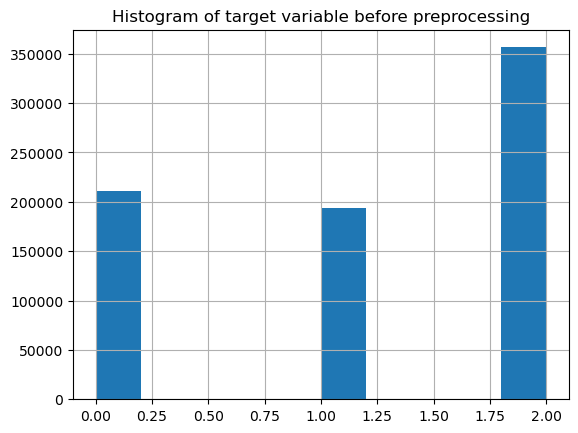

Number of deleted outliers =  63953
Selected features:  ['fps_mean' 'rtt_mean' 'bitrate_mean' 'packet_loss_rate']


In [9]:
Train_df = pd.read_csv('stream_quality_train.csv')
Test_df = pd.read_csv('stream_quality_test.csv')

Train_instance = Feature_Engineering(Train_df)
Train_instance.y.hist()
plt.title("Histogram of target variable before preprocessing")
plt.show()

"""Train data:"""
#Outliers detection:
Train_instance.remove_outliers()
#Balancing the data:
# Train_instance.balancing_data()
#Scaling the data:
Train_instance.scale_data()
#List of selected features:
Important_features = Train_instance.importance_of_features()

"""Test data:"""
Test_instance = Feature_Engineering(Test_df)
Test_instance.X = Test_instance.X[Important_features]
Test_instance.scale_data()

#Converting to numpy arrays:
X_train,y_train = np.array(Train_instance.X),np.array(Train_instance.y)
X_test,y_test = np.array(Test_instance.X),np.array(Test_instance.y)

#### Task 1.1

**Main goal of Task 1.1:** Implementation of Deep learning model predicting stream quality using cloud gaming stream metrics. <br>

***2)Implementation of Deep learning models:*** <br>
    a) Initialization of three models with different architecture (different number of layers and hidden units) <br>
    b) Splitting the data to train and validation <br>
    c) Training models on randomly selected input data and checking accuracy and f1-score on validation <br>
    d) Collection of predictive data from individual models for democratic decision making <br>
    e) Finally, calculation accuracy and f1-score on test data and comparing results between separate models and teamworking models **(bagging)** <br>
    f) Plotting histogram of true and predicted target variable <br>
    G) Plotting confusion matrix <br>

Building three PyTorch classification models with different architectures

In [4]:
class MCLR1(nn.Module):
     def __init__(self
                  , input_dim, output_dim ,hidden_units = 8
                 ): 
         super(MCLR1, self).__init__()
         self.linear_layer_stack = nn.Sequential(
             nn.Linear(in_features=input_dim, out_features=hidden_units+0),
             nn.ReLU(),
             nn.Linear(in_features=hidden_units+0, out_features=hidden_units-2),
             nn.ReLU(),
             nn.Linear(in_features=hidden_units-2, out_features=hidden_units-4),
             nn.ReLU(),
             nn.Linear(in_features=hidden_units-4, out_features=output_dim)
         )
     def forward(self, x):
         return self.linear_layer_stack(x)
        
class MCLR2(nn.Module):
     def __init__(self
                  , input_dim, output_dim ,hidden_units = 10
                 ): 
         super(MCLR2, self).__init__()
         self.linear_layer_stack = nn.Sequential(
             nn.Linear(in_features=input_dim, out_features=hidden_units+0),
             nn.ReLU(),
             nn.Linear(in_features=hidden_units+0, out_features=hidden_units-1),
             nn.ReLU(),
             nn.Linear(in_features=hidden_units-1, out_features=hidden_units-2),
             nn.ReLU(),
             nn.Linear(in_features=hidden_units-2, out_features=hidden_units-3),
             nn.ReLU(),
             nn.Linear(in_features=hidden_units-3, out_features=output_dim)
         )
     def forward(self, x):
         return self.linear_layer_stack(x)
        
class MCLR3(nn.Module):
     def __init__(self
                  , input_dim, output_dim ,hidden_units = 10
                 ): 
         super(MCLR3, self).__init__()
         self.linear_layer_stack = nn.Sequential(
             nn.Linear(in_features=input_dim, out_features=hidden_units+0),
             nn.ReLU(),
             nn.Linear(in_features=hidden_units+0, out_features=hidden_units-5),
             nn.ReLU(),
             nn.Linear(in_features=hidden_units-5, out_features=output_dim)
         )
     def forward(self, x):
         return self.linear_layer_stack(x)

Fitting the model to data

In [5]:
class Neural_network():
    counter=0
    def __init__(self,X,y,epochs,learning_rate):
        self.X = torch.from_numpy(X).float().to(device)
        self.y = torch.from_numpy(y).long().to(device)
        #NN-parameters:
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.input_dim = len(Important_features) #Input features
        self.output_dim = int(Train_df.y.unique().sum()) #Num of classes
        
        Neural_network.counter+=1
    
    def get_model(self):
        """Initializing the Model,Loss Function and the Optimizer"""
        if Neural_network.counter == 0 :
            self.model = MCLR1(self.input_dim,self.output_dim).to(device)
        elif Neural_network.counter == 1 : 
            self.model = MCLR2(self.input_dim,self.output_dim).to(device)
        else:
            self.model = MCLR3(self.input_dim,self.output_dim).to(device)
            
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        
    def accuracy_fn(self,y_pred,y):
        """Function for calculating accuracy"""
        y_pred_softmax = torch.softmax(y_pred, dim=1).argmax(dim=1)
        correct = torch.eq(y, y_pred_softmax).sum().item()
        acc = (correct / len(y_pred)) * 100 
        return acc
    
    def model_train(self,writer):
        """Training NN ensemble"""
        for epoch in range(self.epochs+1):
            #Training:
            self.model.train()
            #Forward pass:
            self.y_pred = self.model(self.X)
            #Calculate loss and accuracy:
            loss = self.criterion(self.y_pred, self.y)
            acc = self.accuracy_fn(self.y_pred,self.y)
            #Optimizer zero grad:
            self.optimizer.zero_grad()
            #Loss backward:
            loss.backward()
            #Optimizer step:
            self.optimizer.step()
            #Print result:
            if epoch == self.epochs:      
                # printing loss values on every 10 epochs to keep track
                print("Finished model № : %d" % Neural_network.counter)
                print("Accuracy on train set : %f" % acc)
            #Add scalaras to writter:
            writer.add_scalar('training loss',
                loss, epoch)
            writer.add_scalar('training accuracy',
                acc , epoch)

Making predictions and evaluating a model

In [6]:
class model_performance:
    def __init__(self,epochs,learning_rate,wrriter):
        self.train_valid_split()
        bs_x,bs_y = self.bootstrap(self.X_train,self.y_train)
        self.NN = Neural_network(bs_x,bs_y,epochs = epochs , learning_rate = learning_rate)
        self.NN.get_model()
        self.NN.model_train(writer)
        
    def train_valid_split(self):
        """Splitting to 80% Train and 20% Validation"""
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=21)
        self.X_val = torch.from_numpy(self.X_val).float().to(device)
        self.y_val = torch.from_numpy(self.y_val).long().to(device)
        
    def bootstrap(self,X, y):
        """Random indecies generator"""
        ind = np.random.randint(0,X.shape[0],X.shape[0])
        return X[ind,:] , y[ind]
    
    def prediction(self,test):
        self.NN.model.eval()
        with torch.inference_mode():
            test_pred = self.NN.model(torch.from_numpy(test).float().to(device))
        return test_pred

In [7]:
Number_of_models = 3
epochs = np.array([40,40,40]) * 100
learning_rates = np.array([1,3,5]) * 0.1

base_pred = np.zeros((X_test.shape[0],Number_of_models),dtype = int)
Neural_network.counter = 0

for i in range(Number_of_models):
    writer = SummaryWriter('runs/Task2.1/model' + str(i))
    NN = model_performance(epochs = epochs[i] , learning_rate = learning_rates[i] , wrriter = writer)
    print("Accuracy on validation set : %f\n" % NN.NN.accuracy_fn(y_pred=NN.NN.model(NN.X_val),y=NN.y_val))
    base_pred[:,i] = torch.max(NN.prediction(X_test).data,1)[1].cpu().detach().numpy()

pred = mode(base_pred, axis=1)[0].ravel()
# Create a dataframe, containing accuracy and f1-score for models and ensemble
Accuracy_list , F1_list = [],[]
for i in range(Number_of_models):
    Accuracy_list.append(accuracy_score(y_test, base_pred[:,i]))
    F1_list.append(f1_score(y_test, base_pred[:,i], average='weighted'))
Accuracy_list.append(accuracy_score(y_test, pred))
F1_list.append(f1_score(y_test, pred, average='weighted'))  
d = {'Accuracy' : Accuracy_list , 'F1-score' : F1_list}
Metrics_Df = pd.DataFrame(data=d, index=["Model№1", "Model№2", "Model№3","Ensemble"])
Metrics_Df.head()

Finished model № : 1
Accuracy on train set : 84.739194
Accuracy on validation set : 84.886037

Finished model № : 2
Accuracy on train set : 85.090748
Accuracy on validation set : 84.979390

Finished model № : 3
Accuracy on train set : 85.077436
Accuracy on validation set : 84.889982



C:\Users\Amir\AppData\Local\Temp\ipykernel_17988\2848847665.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  pred = mode(base_pred, axis=1)[0].ravel()


,Accuracy,F1-score
Model№1,0.849836,0.849626
Model№2,0.850298,0.849549
Model№3,0.847805,0.846472
Ensemble,0.850367,0.849630


Plot confusion matrix

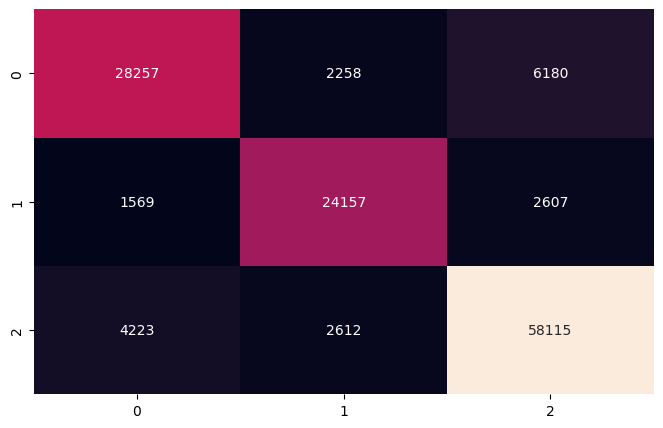

In [8]:
cf_matrix = confusion_matrix(y_test, pred)
plt.subplots(figsize=(8, 5))
sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")
plt.show()

Comparing test values with predicted ones

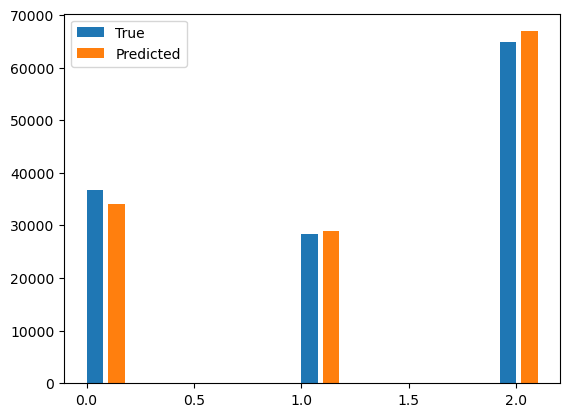

In [9]:
plt.hist(y_test, bins='auto',label = 'True')
plt.hist(pred+0.1, bins='auto',label = 'Predicted')
plt.legend()
plt.show()

***Conclusion of Task 1.1:*** It was not possible to achieve the set mark of exactly 90%. Our model only managed to achieve 85%. Moreover, the ensemble copes at about the same level as individual models. Moreover, the values of the metrics, due to the randomness in the choice of data, can also become worse. This may be due to insufficient data preprocessing. Judging by the graphs, the models do a better job of guessing a certain value, and the main error falls on the 2 remaining classes. However, balancing the data using the SMOTE algorithm degrades the metrics. In addition, I would like to know and discuss the solution to this problem. Also it's hard to tell about underfitting and overfitting because of unsignificant difference between used metrics.<br>
Possible solutions:<br>
1) Significantly increase the number of neural network parameters <br>
2) The abolition of democracy. Initialization of an additional neural network to find a suitable prediction <br>
3) Increase the data<br>

#### Task 1.2

**Main goal of Task 1.2:** The task is to select, train and evaluate an appropriate ML model that will provide an ability to understand why a specific prediction was achieved. <br>

***2)Implementation of RandomForest model:*** <br>
    a) Training DecisionTreeClassifier's ensemble (RandomForest)     <br>
    b) Target variable prediction on test data <br>
    c) Calculation of accuracy and f1-score and comparing with single DecisionTreeClassifier <br>
    d) Visualization decision trees using Graphviz <br>
    <br>

Creating class for operating with model

In [10]:
class Decision_tree_ensemble:
    def __init__(self,X,y):
        self.X = X
        self.y = y

    def model_train(self,n_trees):
        """Training DecisionTreeClassifier's ensemble (RandomForest)"""
        self.n_trees = n_trees
        indx = np.random.randint(0,len(self.y),len(self.y))
        self.rf = RandomForestClassifier(\
                                         n_estimators=n_trees
                                         ,max_features=None
                                         ,criterion="entropy"
                                         ,max_depth=10
                                        ) 
        self.rf = self.rf.fit(self.X,self.y)
    
    def model_predict(self,X_test):
        """Predicting DecisionTreeClassifier's ensemble (RandomForest)"""
        #Predictions for all samples and classifiers:    
        self.base_pred = self.rf.predict(X_test)
            
    def metrics(self,X_test,y_test):
        """Calculating Accuracy and f1-score for the model on test set"""
        pred = self.base_pred
        acc = accuracy_score(y_test,pred)
        f1_s = f1_score(y_test,pred, average='weighted')
        print("Bagging accuracy:",acc)
        print("Bagging f1-score:",f1_s)
        
    def plot_tree(self,number_of_tree_in_the_forest):
        """Visualization of tree with graphviz-library"""
        dot_data = tree.export_graphviz(self.rf[number_of_tree_in_the_forest], out_file=None,
                                        feature_names=Important_features,
                                        class_names=['0','1','2'],
                                        filled=True, rounded=True,
                                        special_characters=True)
        return graphviz.Source(dot_data)

Implementation and plotting

In [11]:
Decision_instance = Decision_tree_ensemble(X_train,y_train)
#Training RandomForest:
Decision_instance.model_train(n_trees=10)
#Prediction:
Decision_instance.model_predict(X_test)
#Calculation Accuracy and f1-score:
Decision_instance.metrics(X_test,y_test)

#Comparing with single Decision tree:
Tree = tree.DecisionTreeClassifier(max_features=None,criterion="entropy",max_depth=10) 
Tree.fit(X_train, y_train)
pred = Tree.predict(X_test)
A_score = accuracy_score(y_test, pred)
F1_score = f1_score(y_test,pred, average='weighted')
print("Single tree accuracy:", A_score)
print("Single tree f1-score:", F1_score)

Bagging accuracy: 0.8509286186893167
Bagging f1-score: 0.8505919373440488
Single tree accuracy: 0.8488821185123636
Single tree f1-score: 0.8485203035348095


In [21]:
text_representation = tree.export_text(Decision_instance.rf[0])
print(text_representation)

|--- feature_1 <= 0.29
|   |--- feature_2 <= 0.33
|   |   |--- feature_2 <= 0.21
|   |   |   |--- feature_2 <= 0.10
|   |   |   |   |--- feature_2 <= 0.03
|   |   |   |   |   |--- feature_1 <= 0.19
|   |   |   |   |   |   |--- feature_0 <= 0.78
|   |   |   |   |   |   |   |--- feature_3 <= 0.25
|   |   |   |   |   |   |   |   |--- feature_3 <= 0.20
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 0.22
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |--- feature_0 >  0.22
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- feature_3 >  0.20
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 0.38
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |--- feature_0 >  0.38
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- feature_3 >  0.25
|   |   |   |   |   |   |   |   |--- feature_1 <= 0.00
|   |   |   |   |   |   |   

***Conclusion of Task 1.2:*** The resulting model exceeded the mark of 85% accuracy and f1-score. But still, it differs by only a few percent from a single tree. What indicates a problem in the data.

#### REPORT FOR TASK 1:

**Main goal of Task 1.1:** Implementation of Deep learning model predicting stream quality using cloud gaming stream metrics. <br>
<br>
**Task 1.1 steps:** <br>
***1)Feature engineering:*** <br>
    a) Data contains only numerical values, so encoding is not required. <br>
    b) Removing outliers with Z-score method: __result__ - 63953 deleted outliers. <br>
    c) Scaling the data <br>
    d) Selection features with Lasso: __result__ - 'fps_mean' , 'rtt_mean' , 'bitrate_mean' , 'packet_loss_rate' features were selected. <br>
      
***2)Implementation of Deep learning models:*** <br>
    a) Initialization of three models with different architecture (different number of layers and hidden units) <br>
    b) Splitting the data to train and validation <br>
    c) Training models on randomly selected input data and checking accuracy and f1-score on validation <br>
    d) Collection of predictive data from individual models for democratic decision making <br>
    e) Finally, calculation accuracy and f1-score on test data and comparing results between separate models and teamworking models **(bagging)** <br>
    f) Plotting histogram of true and predicted target variable <br>
    G) Plotting confusion matrix <br>
    <br>
    ***Conclusion of Task 1.1:*** ***Conclusion of Task 1.1:*** It was not possible to achieve the set mark of exactly 90%. Our model only managed to achieve 85%. Moreover, the ensemble copes at about the same level as individual models. Moreover, the values of the metrics, due to the randomness in the choice of data, can also become worse. This may be due to insufficient data preprocessing. Judging by the graphs, the models do a better job of guessing a certain value, and the main error falls on the 2 remaining classes. However, balancing the data using the SMOTE algorithm degrades the metrics. In addition, I would like to know and discuss the solution to this problem. Also it's hard to tell about underfitting and overfitting because of unsignificant difference between used metrics.<br>
Possible solutions:<br>
1) Significantly increase the number of neural network parameters <br>
2) The abolition of democracy. Initialization of an additional neural network to find a suitable prediction <br>
3) Increase the data<br>
    <br>
    <br>
**Main goal of Task 1.2:** The task is to select, train and evaluate an appropriate ML model that will provide an ability to understand why a specific prediction was achieved. <br>
**Task 1.2 steps:** <br>
***1)Feature engineering:*** <br>
    Same as in Task 1.1 <br>
***2)Implementation of RandomForest model:*** <br>
    a) Training DecisionTreeClassifier's ensemble (RandomForest)     <br>
    b) Target variable prediction on test data <br>
    c) Calculation of accuracy and f1-score and comparing with single DecisionTreeClassifier <br>
    d) Visualization decision trees using Graphviz <br>
    <br>
    ***Conclusion of Task 1.2:*** The resulting model exceeded the mark of 85% accuracy and f1-score. But still, it differs by only a few percent from a single tree. What indicates a problem in the data.